# Whale Detection Challenge : 2_layer

Method overview : FFT to convert the sound tracks into spectrograms, and apply distinct preprocessing methods such as clipping, noise removal, PCEN and filters. After preprocessing we feed the spectrograms into state of the art light CNN models such as Resnet 18, VGG 16 or GoogleNet to identify right whale call patterns and perform classification. We may also try the removal of pooling layers in the networks and see if it causes better outcome.

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


## Import and Load Data

In [2]:
num_classes = 2
batch_size = 32
num_epochs = 100
feature_extract = True
groups = 3
vis_batch = 4

In [3]:
data_dir = "data/"
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((40,500)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((40,500)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x+"_prep_10_2layers/"), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Model

In [4]:
# The 2-layer model
class small_model(nn.Module):
    # input size 40*500
    # image = cv2.resize(image, (40, 500), interpolation = cv2.INTER_CUBIC)

    def __init__(self):
        super(small_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=True)
        self.dropout = nn.Dropout2d(p = 0.3)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=(3, 3), bias=False)
        self.bn2 = nn.BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 100), stride=(4, 100), padding=0, dilation=1, ceil_mode=True)

        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 2)
        self.softmax = nn.Softmax()
        
#         self.dropout = nn.Dropout2d(p = 0.3)
        
    def forward(self, x):
        # CNN 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(self.pool1(x))
        
        # CNN 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(self.pool2(x))
        
        # Flatten
        x = self.flat(x)
        
        # Dense
        x = self.dropout(F.relu(self.fc1(x)))
        # Output
        x = self.softmax(self.fc2(x))
        return x


In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = small_model()
    num_ftrs = model_ft.fc1.out_features
    model_ft.fc2 = nn.Linear(num_ftrs, num_classes)
    input_size = (40, 500)  
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

small_model(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=True)
  (dropout): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn2): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(4, 100), stride=(4, 100), padding=0, dilation=1, ceil_mode=True)
  (flat): Flatten()
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)


## Training Section

### training fuction

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    history = {'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, best_acc

### optimizer

In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 conv2.weight
	 bn2.weight
	 bn2.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias


### run and save model

In [8]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist, best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
torch.save(model_ft.state_dict(), 'model_weight/2_layer_model_'+str(num_epochs))
print(model_ft.state_dict().keys())

Epoch 0/99
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.5533 Acc: 0.7607
val Loss: 0.5448 Acc: 0.7660

Epoch 1/99
----------
train Loss: 0.5453 Acc: 0.7660
val Loss: 0.5259 Acc: 0.7660

Epoch 2/99
----------
train Loss: 0.5148 Acc: 0.7913
val Loss: 0.4574 Acc: 0.8627

Epoch 3/99
----------
train Loss: 0.4790 Acc: 0.8350
val Loss: 0.4554 Acc: 0.8657

Epoch 4/99
----------
train Loss: 0.4726 Acc: 0.8340
val Loss: 0.4386 Acc: 0.8730

Epoch 5/99
----------
train Loss: 0.4568 Acc: 0.8520
val Loss: 0.4358 Acc: 0.8747

Epoch 6/99
----------
train Loss: 0.4543 Acc: 0.8563
val Loss: 0.4303 Acc: 0.8790

Epoch 7/99
----------
train Loss: 0.4491 Acc: 0.8600
val Loss: 0.4313 Acc: 0.8777

Epoch 8/99
----------
train Loss: 0.4365 Acc: 0.8790
val Loss: 0.4296 Acc: 0.8800

Epoch 9/99
----------
train Loss: 0.4442 Acc: 0.8653
val Loss: 0.4266 Acc: 0.8790

Epoch 10/99
----------
train Loss: 0.4422 Acc: 0.8650
val Loss: 0.4254 Acc: 0.8810

Epoch 11/99
----------
train Loss: 0.4352 Acc: 0.8750
val Loss: 0.4280 Acc: 0.8810

Epoch 12/99
----------
t

train Loss: 0.3354 Acc: 0.9797
val Loss: 0.4156 Acc: 0.8900

Epoch 99/99
----------
train Loss: 0.3353 Acc: 0.9807
val Loss: 0.4169 Acc: 0.8883

Training complete in 7m 15s
Best val Acc: 0.895667
odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


### plot loss and accuracy

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])


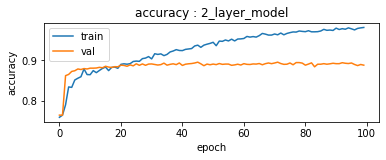

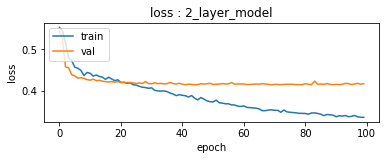

tensor(0.8957, device='cuda:0', dtype=torch.float64)


In [9]:
print(hist.keys())

#### Fill in plot #####
#Plot accuracy vs epoch
plt.subplot(211)

plt.plot(hist['train_acc'])
plt.plot(hist['val_acc'])
plt.title('accuracy : 2_layer_model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot loss vs epoch
plt.subplot(212)
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.title('loss : 2_layer_model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(best_acc)

### load model and prediction

In [33]:
def forward_vis(vis_loader, groups):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = models.googlenet(aux_logits=False)
    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    # load best model weights
    state_dict = torch.load('model_weight/2_layer_model_'+str(num_epochs))
    print(state_dict.keys())
    model.load_state_dict(torch.load('model_weight/2_layer_model_'+str(num_epochs)))
    model.to(device)
    model.eval()   # Set model to evaluate mode
    # Iterate over data.
    cnt=0
    vis_dict = {'inputs':np.empty([groups,vis_batch,3,224,224]),'outputs':np.empty([groups,vis_batch,num_classes]),'labels':np.empty([groups,vis_batch]),'preds':np.empty([groups,vis_batch])}
    for inputs, labels in vis_loader:
            if(cnt==groups):
                break;
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            vis_dict['inputs'][cnt,:,:,:,:]=inputs.cpu().numpy()
            vis_dict['labels'][cnt,:]=labels.cpu().numpy()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                vis_dict['outputs'][cnt,:,:]=outputs.cpu().numpy()
                vis_dict['preds'][cnt,:]=preds.cpu().numpy()
            cnt+=1
            

    time_elapsed = time.time() - since
    print()
    print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return vis_dict

vis_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=vis_batch, shuffle=True, num_workers=8)
vis_dict = forward_vis(vis_loader, groups)
print(vis_dict['inputs'].shape)
print(vis_dict['outputs'].shape)
print(vis_dict['labels'].shape)
print(vis_dict['preds'].shape)

cuda:0
odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


RuntimeError: Error(s) in loading state_dict for GoogLeNet:
	Missing key(s) in state_dict: "conv1.conv.weight", "conv1.bn.weight", "conv1.bn.bias", "conv1.bn.running_mean", "conv1.bn.running_var", "conv2.conv.weight", "conv2.bn.weight", "conv2.bn.bias", "conv2.bn.running_mean", "conv2.bn.running_var", "conv3.conv.weight", "conv3.bn.weight", "conv3.bn.bias", "conv3.bn.running_mean", "conv3.bn.running_var", "inception3a.branch1.conv.weight", "inception3a.branch1.bn.weight", "inception3a.branch1.bn.bias", "inception3a.branch1.bn.running_mean", "inception3a.branch1.bn.running_var", "inception3a.branch2.0.conv.weight", "inception3a.branch2.0.bn.weight", "inception3a.branch2.0.bn.bias", "inception3a.branch2.0.bn.running_mean", "inception3a.branch2.0.bn.running_var", "inception3a.branch2.1.conv.weight", "inception3a.branch2.1.bn.weight", "inception3a.branch2.1.bn.bias", "inception3a.branch2.1.bn.running_mean", "inception3a.branch2.1.bn.running_var", "inception3a.branch3.0.conv.weight", "inception3a.branch3.0.bn.weight", "inception3a.branch3.0.bn.bias", "inception3a.branch3.0.bn.running_mean", "inception3a.branch3.0.bn.running_var", "inception3a.branch3.1.conv.weight", "inception3a.branch3.1.bn.weight", "inception3a.branch3.1.bn.bias", "inception3a.branch3.1.bn.running_mean", "inception3a.branch3.1.bn.running_var", "inception3a.branch4.1.conv.weight", "inception3a.branch4.1.bn.weight", "inception3a.branch4.1.bn.bias", "inception3a.branch4.1.bn.running_mean", "inception3a.branch4.1.bn.running_var", "inception3b.branch1.conv.weight", "inception3b.branch1.bn.weight", "inception3b.branch1.bn.bias", "inception3b.branch1.bn.running_mean", "inception3b.branch1.bn.running_var", "inception3b.branch2.0.conv.weight", "inception3b.branch2.0.bn.weight", "inception3b.branch2.0.bn.bias", "inception3b.branch2.0.bn.running_mean", "inception3b.branch2.0.bn.running_var", "inception3b.branch2.1.conv.weight", "inception3b.branch2.1.bn.weight", "inception3b.branch2.1.bn.bias", "inception3b.branch2.1.bn.running_mean", "inception3b.branch2.1.bn.running_var", "inception3b.branch3.0.conv.weight", "inception3b.branch3.0.bn.weight", "inception3b.branch3.0.bn.bias", "inception3b.branch3.0.bn.running_mean", "inception3b.branch3.0.bn.running_var", "inception3b.branch3.1.conv.weight", "inception3b.branch3.1.bn.weight", "inception3b.branch3.1.bn.bias", "inception3b.branch3.1.bn.running_mean", "inception3b.branch3.1.bn.running_var", "inception3b.branch4.1.conv.weight", "inception3b.branch4.1.bn.weight", "inception3b.branch4.1.bn.bias", "inception3b.branch4.1.bn.running_mean", "inception3b.branch4.1.bn.running_var", "inception4a.branch1.conv.weight", "inception4a.branch1.bn.weight", "inception4a.branch1.bn.bias", "inception4a.branch1.bn.running_mean", "inception4a.branch1.bn.running_var", "inception4a.branch2.0.conv.weight", "inception4a.branch2.0.bn.weight", "inception4a.branch2.0.bn.bias", "inception4a.branch2.0.bn.running_mean", "inception4a.branch2.0.bn.running_var", "inception4a.branch2.1.conv.weight", "inception4a.branch2.1.bn.weight", "inception4a.branch2.1.bn.bias", "inception4a.branch2.1.bn.running_mean", "inception4a.branch2.1.bn.running_var", "inception4a.branch3.0.conv.weight", "inception4a.branch3.0.bn.weight", "inception4a.branch3.0.bn.bias", "inception4a.branch3.0.bn.running_mean", "inception4a.branch3.0.bn.running_var", "inception4a.branch3.1.conv.weight", "inception4a.branch3.1.bn.weight", "inception4a.branch3.1.bn.bias", "inception4a.branch3.1.bn.running_mean", "inception4a.branch3.1.bn.running_var", "inception4a.branch4.1.conv.weight", "inception4a.branch4.1.bn.weight", "inception4a.branch4.1.bn.bias", "inception4a.branch4.1.bn.running_mean", "inception4a.branch4.1.bn.running_var", "inception4b.branch1.conv.weight", "inception4b.branch1.bn.weight", "inception4b.branch1.bn.bias", "inception4b.branch1.bn.running_mean", "inception4b.branch1.bn.running_var", "inception4b.branch2.0.conv.weight", "inception4b.branch2.0.bn.weight", "inception4b.branch2.0.bn.bias", "inception4b.branch2.0.bn.running_mean", "inception4b.branch2.0.bn.running_var", "inception4b.branch2.1.conv.weight", "inception4b.branch2.1.bn.weight", "inception4b.branch2.1.bn.bias", "inception4b.branch2.1.bn.running_mean", "inception4b.branch2.1.bn.running_var", "inception4b.branch3.0.conv.weight", "inception4b.branch3.0.bn.weight", "inception4b.branch3.0.bn.bias", "inception4b.branch3.0.bn.running_mean", "inception4b.branch3.0.bn.running_var", "inception4b.branch3.1.conv.weight", "inception4b.branch3.1.bn.weight", "inception4b.branch3.1.bn.bias", "inception4b.branch3.1.bn.running_mean", "inception4b.branch3.1.bn.running_var", "inception4b.branch4.1.conv.weight", "inception4b.branch4.1.bn.weight", "inception4b.branch4.1.bn.bias", "inception4b.branch4.1.bn.running_mean", "inception4b.branch4.1.bn.running_var", "inception4c.branch1.conv.weight", "inception4c.branch1.bn.weight", "inception4c.branch1.bn.bias", "inception4c.branch1.bn.running_mean", "inception4c.branch1.bn.running_var", "inception4c.branch2.0.conv.weight", "inception4c.branch2.0.bn.weight", "inception4c.branch2.0.bn.bias", "inception4c.branch2.0.bn.running_mean", "inception4c.branch2.0.bn.running_var", "inception4c.branch2.1.conv.weight", "inception4c.branch2.1.bn.weight", "inception4c.branch2.1.bn.bias", "inception4c.branch2.1.bn.running_mean", "inception4c.branch2.1.bn.running_var", "inception4c.branch3.0.conv.weight", "inception4c.branch3.0.bn.weight", "inception4c.branch3.0.bn.bias", "inception4c.branch3.0.bn.running_mean", "inception4c.branch3.0.bn.running_var", "inception4c.branch3.1.conv.weight", "inception4c.branch3.1.bn.weight", "inception4c.branch3.1.bn.bias", "inception4c.branch3.1.bn.running_mean", "inception4c.branch3.1.bn.running_var", "inception4c.branch4.1.conv.weight", "inception4c.branch4.1.bn.weight", "inception4c.branch4.1.bn.bias", "inception4c.branch4.1.bn.running_mean", "inception4c.branch4.1.bn.running_var", "inception4d.branch1.conv.weight", "inception4d.branch1.bn.weight", "inception4d.branch1.bn.bias", "inception4d.branch1.bn.running_mean", "inception4d.branch1.bn.running_var", "inception4d.branch2.0.conv.weight", "inception4d.branch2.0.bn.weight", "inception4d.branch2.0.bn.bias", "inception4d.branch2.0.bn.running_mean", "inception4d.branch2.0.bn.running_var", "inception4d.branch2.1.conv.weight", "inception4d.branch2.1.bn.weight", "inception4d.branch2.1.bn.bias", "inception4d.branch2.1.bn.running_mean", "inception4d.branch2.1.bn.running_var", "inception4d.branch3.0.conv.weight", "inception4d.branch3.0.bn.weight", "inception4d.branch3.0.bn.bias", "inception4d.branch3.0.bn.running_mean", "inception4d.branch3.0.bn.running_var", "inception4d.branch3.1.conv.weight", "inception4d.branch3.1.bn.weight", "inception4d.branch3.1.bn.bias", "inception4d.branch3.1.bn.running_mean", "inception4d.branch3.1.bn.running_var", "inception4d.branch4.1.conv.weight", "inception4d.branch4.1.bn.weight", "inception4d.branch4.1.bn.bias", "inception4d.branch4.1.bn.running_mean", "inception4d.branch4.1.bn.running_var", "inception4e.branch1.conv.weight", "inception4e.branch1.bn.weight", "inception4e.branch1.bn.bias", "inception4e.branch1.bn.running_mean", "inception4e.branch1.bn.running_var", "inception4e.branch2.0.conv.weight", "inception4e.branch2.0.bn.weight", "inception4e.branch2.0.bn.bias", "inception4e.branch2.0.bn.running_mean", "inception4e.branch2.0.bn.running_var", "inception4e.branch2.1.conv.weight", "inception4e.branch2.1.bn.weight", "inception4e.branch2.1.bn.bias", "inception4e.branch2.1.bn.running_mean", "inception4e.branch2.1.bn.running_var", "inception4e.branch3.0.conv.weight", "inception4e.branch3.0.bn.weight", "inception4e.branch3.0.bn.bias", "inception4e.branch3.0.bn.running_mean", "inception4e.branch3.0.bn.running_var", "inception4e.branch3.1.conv.weight", "inception4e.branch3.1.bn.weight", "inception4e.branch3.1.bn.bias", "inception4e.branch3.1.bn.running_mean", "inception4e.branch3.1.bn.running_var", "inception4e.branch4.1.conv.weight", "inception4e.branch4.1.bn.weight", "inception4e.branch4.1.bn.bias", "inception4e.branch4.1.bn.running_mean", "inception4e.branch4.1.bn.running_var", "inception5a.branch1.conv.weight", "inception5a.branch1.bn.weight", "inception5a.branch1.bn.bias", "inception5a.branch1.bn.running_mean", "inception5a.branch1.bn.running_var", "inception5a.branch2.0.conv.weight", "inception5a.branch2.0.bn.weight", "inception5a.branch2.0.bn.bias", "inception5a.branch2.0.bn.running_mean", "inception5a.branch2.0.bn.running_var", "inception5a.branch2.1.conv.weight", "inception5a.branch2.1.bn.weight", "inception5a.branch2.1.bn.bias", "inception5a.branch2.1.bn.running_mean", "inception5a.branch2.1.bn.running_var", "inception5a.branch3.0.conv.weight", "inception5a.branch3.0.bn.weight", "inception5a.branch3.0.bn.bias", "inception5a.branch3.0.bn.running_mean", "inception5a.branch3.0.bn.running_var", "inception5a.branch3.1.conv.weight", "inception5a.branch3.1.bn.weight", "inception5a.branch3.1.bn.bias", "inception5a.branch3.1.bn.running_mean", "inception5a.branch3.1.bn.running_var", "inception5a.branch4.1.conv.weight", "inception5a.branch4.1.bn.weight", "inception5a.branch4.1.bn.bias", "inception5a.branch4.1.bn.running_mean", "inception5a.branch4.1.bn.running_var", "inception5b.branch1.conv.weight", "inception5b.branch1.bn.weight", "inception5b.branch1.bn.bias", "inception5b.branch1.bn.running_mean", "inception5b.branch1.bn.running_var", "inception5b.branch2.0.conv.weight", "inception5b.branch2.0.bn.weight", "inception5b.branch2.0.bn.bias", "inception5b.branch2.0.bn.running_mean", "inception5b.branch2.0.bn.running_var", "inception5b.branch2.1.conv.weight", "inception5b.branch2.1.bn.weight", "inception5b.branch2.1.bn.bias", "inception5b.branch2.1.bn.running_mean", "inception5b.branch2.1.bn.running_var", "inception5b.branch3.0.conv.weight", "inception5b.branch3.0.bn.weight", "inception5b.branch3.0.bn.bias", "inception5b.branch3.0.bn.running_mean", "inception5b.branch3.0.bn.running_var", "inception5b.branch3.1.conv.weight", "inception5b.branch3.1.bn.weight", "inception5b.branch3.1.bn.bias", "inception5b.branch3.1.bn.running_mean", "inception5b.branch3.1.bn.running_var", "inception5b.branch4.1.conv.weight", "inception5b.branch4.1.bn.weight", "inception5b.branch4.1.bn.bias", "inception5b.branch4.1.bn.running_mean", "inception5b.branch4.1.bn.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "conv1.weight", "conv2.weight". 

### visualization 

In [ ]:
for i in range(groups) :
    for j in range(vis_batch) :
        plt.figure(figsize=(15,15))
        plt.subplot(groups,vis_batch,4*i+j+1)
        image = np.moveaxis(np.squeeze(vis_dict['inputs'][i,j]), 0, -1)
        image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
        plt.imshow(image)
        plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,         # ticks along the left edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
        plt.title('preprocessed '+str(i)+' '+str(j))
        plt.xlabel('label : '+str(vis_dict['labels'][i,j])+', pred : '+str(vis_dict['preds'][i,j])+', output : '+str(vis_dict['outputs'][i,j,:]))
plt.show()